In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter

In [84]:
# Step 1: Input the data
data = {
    "Catalyst Loading (mol%)": [0.5, 1, 0.5, 1, 0.5, 1, 0.5, 1],
    "Substrate Conc. (M)": [0.05, 0.05, 0.15, 0.15, 0.05, 0.05, 0.15, 0.15],
    "Temperature (ºC)": [25, 25, 25, 25, 55, 55, 55, 55],
    "Yield (%)": [11.48203592, 52.50440934, 68.64144531, 98.11199825,
                  5.434570089, 15.50803655, 54.78813836, 100]
}
df = pd.DataFrame(data)

# Step 2: Encode the factors for a 2^3 design
df['Catalyst'] = df['Catalyst Loading (mol%)'].apply(lambda x: -1 if x == 0.5 else 1)
df['Concentration'] = df['Substrate Conc. (M)'].apply(lambda x: -1 if x == 0.05 else 1)
df['Temperature'] = df['Temperature (ºC)'].apply(lambda x: -1 if x == 25 else 1)

# Create the design matrix
X = df[['Catalyst', 'Concentration', 'Temperature']].copy()
X['Catalyst*Concentration'] = X['Catalyst'] * X['Concentration']
X['Catalyst*Temperature'] = X['Catalyst'] * X['Temperature']
X['Concentration*Temperature'] = X['Concentration'] * X['Temperature']
X['Catalyst*Concentration*Temperature'] = (
        X['Catalyst'] * X['Concentration'] * X['Temperature']
)
y = df['Yield (%)']

In [133]:
# Calculate effects for 2^3 factorial design
n = len(df)
k = 3

# Main Effects
# A: Catalyst effect
A_high = df[df['Catalyst'] == 1]['Yield (%)'].sum()
A_low = df[df['Catalyst'] == -1]['Yield (%)'].sum()
effect_A = (A_high - A_low) / (2 ** (k - 1))

# B: Concentration effect
B_high = df[df['Concentration'] == 1]['Yield (%)'].sum()
B_low = df[df['Concentration'] == -1]['Yield (%)'].sum()
effect_B = (B_high - B_low) / (2 ** (k - 1))

# C: Temperature effect
C_high = df[df['Temperature'] == 1]['Yield (%)'].sum()
C_low = df[df['Temperature'] == -1]['Yield (%)'].sum()
effect_C = (C_high - C_low) / (2 ** (k - 1))

# Two-factor interactions
# AB interaction
AB_high = df[(df['Catalyst'] * df['Concentration']) == 1]['Yield (%)'].sum()
AB_low = df[(df['Catalyst'] * df['Concentration']) == -1]['Yield (%)'].sum()
effect_AB = (AB_high - AB_low) / (2 ** (k - 1))

# AC interaction
AC_high = df[(df['Catalyst'] * df['Temperature']) == 1]['Yield (%)'].sum()
AC_low = df[(df['Catalyst'] * df['Temperature']) == -1]['Yield (%)'].sum()
effect_AC = (AC_high - AC_low) / (2 ** (k - 1))

# BC interaction
BC_high = df[(df['Concentration'] * df['Temperature']) == 1]['Yield (%)'].sum()
BC_low = df[(df['Concentration'] * df['Temperature']) == -1]['Yield (%)'].sum()
effect_BC = (BC_high - BC_low) / (2 ** (k - 1))

# Three-factor interaction
# ABC interaction
ABC_high = df[(df['Catalyst'] * df['Concentration'] * df['Temperature']) == 1]['Yield (%)'].sum()
ABC_low = df[(df['Catalyst'] * df['Concentration'] * df['Temperature']) == -1]['Yield (%)'].sum()
effect_ABC = (ABC_high - ABC_low) / (2 ** (k - 1))

effects = {
    'Catalyst (A)': effect_A,
    'Concentration (B)': effect_B,
    'Temperature (C)': effect_C,
    'A×B': effect_AB,
    'A×C': effect_AC,
    'B×C': effect_BC,
    'A×B×C': effect_ABC
}

print("Calculated Effects:")
for name, effect in effects.items():
    print(f"{name:15}: {effect:8.2f}")
print()

Calculated Effects:
Catalyst (A)   :    31.44
Concentration (B):    59.15
Temperature (C):   -13.75
A×B            :     5.90
A×C            :    -3.80
B×C            :     7.77
A×B×C          :    11.67



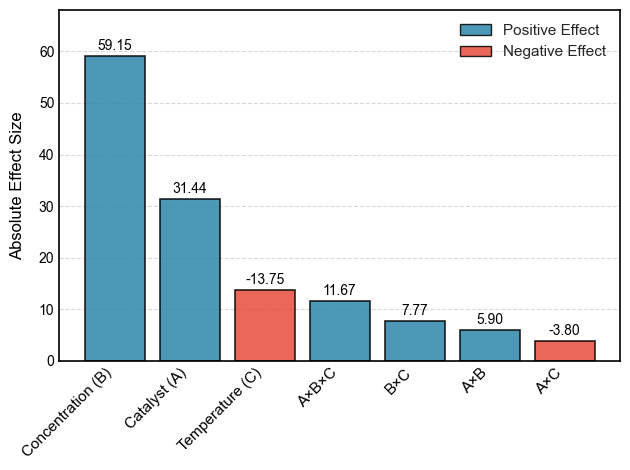

In [134]:
fig, ax = plt.subplots()

# Sort effects by absolute value (descending)
sorted_effects = dict(sorted(effects.items(), key=lambda x: abs(x[1]), reverse=True))
names = list(sorted_effects.keys())
values = list(sorted_effects.values())
abs_values = [abs(v) for v in values]

positive_color = '#2E86AB'
negative_color = '#E74C3C'
bar_edge_color = 'black'
frame_color = 'black'

# Create bars with black outlines
bars = ax.bar(names, abs_values,
              color=[negative_color if v < 0 else positive_color for v in values],
              edgecolor=bar_edge_color, linewidth=1.2, alpha=0.85)

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2., height + max(abs_values) * 0.01,
            f'{value:.2f}',
            ha='center', va='bottom',
            fontsize=10, color='black', fontweight='normal')

# Frame borders visible
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color(frame_color)
    spine.set_linewidth(1.2)

# Grid styling
ax.grid(True, alpha=0.3, axis='y', color='gray', linestyle='--')
ax.set_axisbelow(True)  # Grid behind bars

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=11, color='black')
plt.yticks(fontsize=10, color='black')

legend_elements = [Patch(facecolor=positive_color, edgecolor='black', label='Positive Effect', alpha=0.85),
                   Patch(facecolor=negative_color, edgecolor='black', label='Negative Effect', alpha=0.85)]
ax.legend(handles=legend_elements,
          loc='upper right',
          framealpha=1,
          edgecolor='black',
          fontsize=11)

ax.set_ylabel('Absolute Effect Size', fontsize=12, labelpad=10, color='black')

# Adjust y-axis limits
ax.set_ylim(top=max(abs_values) * 1.15)

plt.tight_layout()
plt.show()

In [135]:
# Print interpretation
print("Interpretation:")
print("-" * 50)
most_significant = max(effects.items(), key=lambda x: abs(x[1]))
print(f"Most significant effect: {most_significant[0]} ({most_significant[1]:.2f})")

positive_effects = [name for name, effect in sorted_effects.items() if effect > 0]
negative_effects = [name for name, effect in sorted_effects.items() if effect < 0]

print(f"\nPositive effects (increase yield): {', '.join(positive_effects)}")
print(f"Negative effects (decrease yield): {', '.join(negative_effects)}")

# Calculate R-squared for the model
y_mean = df['Yield (%)'].mean()
ss_total = sum((df['Yield (%)'] - y_mean) ** 2)

df_analysis = df.copy()
df_analysis['Fitted'] = (y_mean +
                         effect_A / 2 * df_analysis['Catalyst'] +
                         effect_B / 2 * df_analysis['Concentration'] +
                         effect_C / 2 * df_analysis['Temperature'] +
                         effect_AB / 2 * df_analysis['Catalyst'] * df_analysis['Concentration'] +
                         effect_AC / 2 * df_analysis['Catalyst'] * df_analysis['Temperature'] +
                         effect_BC / 2 * df_analysis['Concentration'] * df_analysis['Temperature'] +
                         effect_ABC / 2 * df_analysis['Catalyst'] * df_analysis['Concentration'] * df_analysis[
                             'Temperature'])

ss_residual = sum((df_analysis['Yield (%)'] - df_analysis['Fitted']) ** 2)
r_squared = 1 - (ss_residual / ss_total)

print(f"\nModel R²: {r_squared:.4f}")
print("\nActual vs Fitted Values:")
for i, row in df_analysis.iterrows():
    print(
        f"Run {i + 1}: Actual = {row['Yield (%)']:6.2f}, Fitted = {row['Fitted']:6.2f}, Residual = {row['Yield (%)'] - row['Fitted']:6.2f}")

Interpretation:
--------------------------------------------------
Most significant effect: Concentration (B) (59.15)

Positive effects (increase yield): Concentration (B), Catalyst (A), A×B×C, B×C, A×B
Negative effects (decrease yield): Temperature (C), A×C

Model R²: 1.0000

Actual vs Fitted Values:
Run 1: Actual =  11.48, Fitted =  11.48, Residual =  -0.00
Run 2: Actual =  52.50, Fitted =  52.50, Residual =   0.00
Run 3: Actual =  68.64, Fitted =  68.64, Residual =   0.00
Run 4: Actual =  98.11, Fitted =  98.11, Residual =   0.00
Run 5: Actual =   5.43, Fitted =   5.43, Residual =  -0.00
Run 6: Actual =  15.51, Fitted =  15.51, Residual =   0.00
Run 7: Actual =  54.79, Fitted =  54.79, Residual =   0.00
Run 8: Actual = 100.00, Fitted = 100.00, Residual =   0.00


In [115]:
y_mean + effect_A / 2 * 1 + effect_B / 2 * -1 + effect_C / 2 * 1 + effect_AB / 2 * -1 + effect_AC / 2 * 1 + effect_BC / 2 * -1 + effect_ABC / 2 * -1

np.float64(15.508036549999993)

In [45]:
cmap = "RdYlGn_r"

C:\Users\Javier\OneDrive\Documents\Python_Scripts\chapter4\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8451 (\N{DEGREE CELSIUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


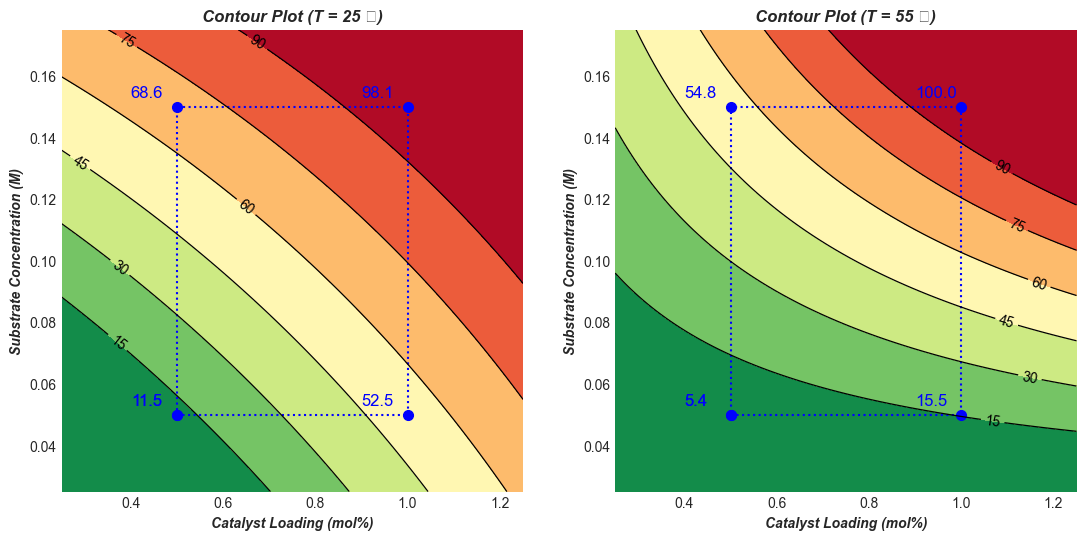

In [136]:
# Catalyst Loading (mol%)
catalyst_real = np.linspace(0.25, 1.25, 100)
# Substrate Concentration (M)
concentration_real = np.linspace(0.025, 0.175, 100)
Catalyst, Concentration = np.meshgrid(catalyst_real, concentration_real)

# Transform real-world values to coded values for prediction
Catalyst_coded = (Catalyst - 0.75) / 0.25  # Coding formula for catalyst loading
Concentration_coded = (Concentration - 0.1) / 0.05  # Coding formula for concentration
Temperature_25_coded = (25 - 40) / 15
Temperature_55_coded = (55 - 40) / 15

# Create subplots for two different temperatures
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

contours = []
for ax, Temperature in zip(axes, [25, 55]):
    Temperature_coded = (Temperature - 40) / 15
    # Predicted response surface
    response_surface = (
            y_mean
            + Catalyst_coded * effect_A / 2
            + Concentration_coded * effect_B / 2
            + Temperature_coded * effect_C / 2
            + Catalyst_coded * Concentration_coded * effect_AB / 2
            + Catalyst_coded * Temperature_coded * effect_AC / 2
            + Concentration_coded * Temperature_coded * effect_BC / 2
            + Catalyst_coded * Concentration_coded * Temperature_coded * effect_ABC / 2
    )

    response_surface = np.clip(response_surface, 0, 100)

    # Plot contour
    contour = ax.contourf(Catalyst, Concentration, response_surface, cmap=cmap, vmax=100)
    contour.set_clim(0, 100)  # Limit color scale to 0-100 for this contour plot
    contours.append(contour)

    ax.set_xlabel('Catalyst Loading (mol%)', weight='bold', style="oblique")
    ax.set_ylabel('Substrate Concentration (M)', weight='bold', style="oblique")
    ax.set_title(f'Contour Plot (T = {Temperature} ℃)', weight='bold', style="oblique")

    # Points ordered to form a square for each temperature
    if Temperature == 25:
        points_order = [
            (0.5, 0.05), (1, 0.05), (1, 0.15), (0.5, 0.15), (0.5, 0.05)  # Closing the loop
        ]
        yield_values = [
            11.48203592, 52.50440934, 98.11199825, 68.64144531, 11.48203592
        ]
    else:  # Temperature == 55
        points_order = [
            (0.5, 0.05), (1, 0.05), (1, 0.15), (0.5, 0.15), (0.5, 0.05)  # Closing the loop
        ]
        yield_values = [
            5.434570089, 15.50803655, 100, 54.78813836, 5.434570089  # Closing the loop with same first yield value
        ]

    catalyst_ordered = [x[0] for x in points_order]
    concentration_ordered = [x[1] for x in points_order]

    # Plot the points and connect them with white lines (square shape)
    ax.plot(catalyst_ordered, concentration_ordered, 'o:', markersize=7, lw=1.5, color="blue")

    # Add the yield values as text next to each point with more spacing
    offset_x = -0.10  # Adjust x spacing
    offset_y = 0.002  # Adjust y spacing
    for i, (x, y) in enumerate(zip(catalyst_ordered, concentration_ordered)):
        ax.text(x + offset_x, y + offset_y, f"{yield_values[i]:.1f}", color='blue', fontsize=12, ha='left', va='bottom')

    # Add contour labels (the values on the contour lines)
    contour_labels = ax.contour(Catalyst, Concentration, response_surface, colors='black', levels=np.arange(15, 101, 15), linewidths=0.9)
    ax.clabel(contour_labels, inline=True, fontsize=10, fmt='%1.0f')

    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2f}'))

# Adjust the layout to prevent overlap
plt.subplots_adjust(right=0.85)

plt.show()

C:\Users\Javier\OneDrive\Documents\Python_Scripts\chapter4\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8451 (\N{DEGREE CELSIUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


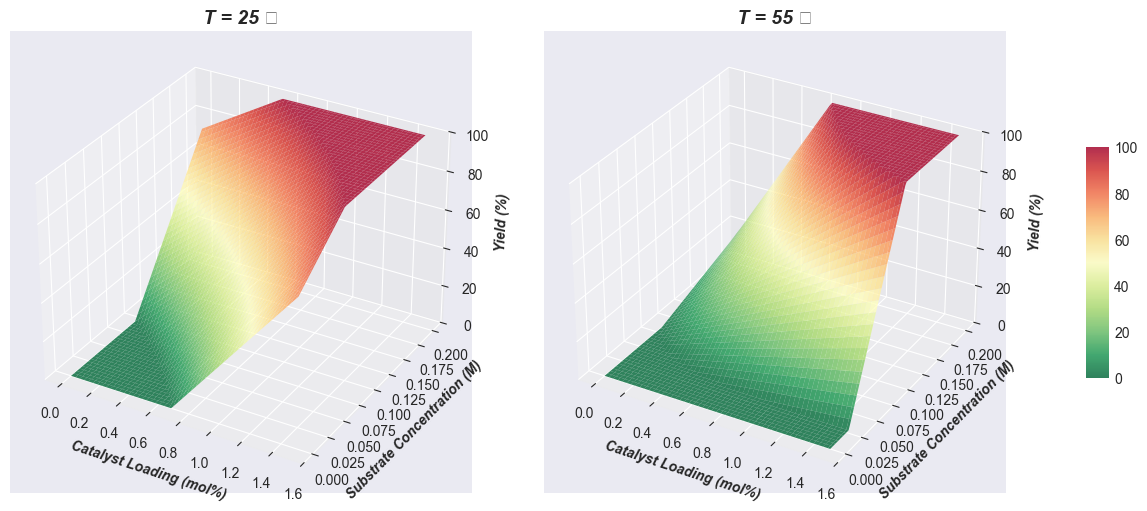

In [137]:
# Catalyst Loading (mol%)
catalyst_real = np.linspace(0.0, 1.5, 100)
# Substrate Concentration (M)
concentration_real = np.linspace(0.0, 0.2, 100)
Catalyst, Concentration = np.meshgrid(catalyst_real, concentration_real)

# Transform real-world values to coded values for prediction
Catalyst_coded = (Catalyst - 0.75) / 0.25  # Coding formula for catalyst loading
Concentration_coded = (Concentration - 0.1) / 0.05  # Coding formula for concentration

# Predict the response surface for T = 25 ºC
Temperature_25_coded = (25 - 40) / 15  # Coded value for T = 25
response_surface_25 = (
        y_mean
        + Catalyst_coded * effect_A / 2
        + Concentration_coded * effect_B / 2
        + Temperature_25_coded * effect_C / 2
        + Catalyst_coded * Concentration_coded * effect_AB / 2
        + Catalyst_coded * Temperature_25_coded * effect_AC / 2
        + Concentration_coded * Temperature_25_coded * effect_BC / 2
        + Catalyst_coded * Concentration_coded * Temperature_25_coded * effect_ABC / 2
)

# Predict the response surface for T = 55 ºC
Temperature_55_coded = (55 - 40) / 15  # Coded value for T = 55
response_surface_55 = (
        y_mean
        + Catalyst_coded * effect_A / 2
        + Concentration_coded * effect_B / 2
        + Temperature_55_coded * effect_C / 2
        + Catalyst_coded * Concentration_coded * effect_AB / 2
        + Catalyst_coded * Temperature_55_coded * effect_AC / 2
        + Concentration_coded * Temperature_55_coded * effect_BC / 2
        + Catalyst_coded * Concentration_coded * Temperature_55_coded * effect_ABC / 2
)

# Clip response surfaces to stay within [0, 100]
response_surface_25 = np.clip(response_surface_25, 0, 100)
response_surface_55 = np.clip(response_surface_55, 0, 100)

# Create a figure with specific layout
fig = plt.figure(figsize=(16, 6))  # Adjust figure size to make space
gs = GridSpec(1, 3, width_ratios=[2, 2, 0.05])  # 2 plots + colorbar column

# Surface for T = 25 ºC
ax1 = fig.add_subplot(gs[0], projection='3d')
surface1 = ax1.plot_surface(
    Catalyst, Concentration, response_surface_25, cmap=cmap, edgecolor='none', alpha=0.8
)
ax1.set_xlabel('Catalyst Loading (mol%)', weight='bold', style="oblique")
ax1.set_ylabel('Substrate Concentration (M)', weight='bold', style="oblique")
ax1.set_zlabel('Yield (%)', weight='bold', style="oblique")
ax1.set_title('T = 25 ℃', fontsize=14, weight='bold', style="oblique")
ax1.set_zlim(0, 100)

# Surface for T = 55 ºC
ax2 = fig.add_subplot(gs[1], projection='3d')
surface2 = ax2.plot_surface(
    Catalyst, Concentration, response_surface_55, cmap=cmap, edgecolor='none', alpha=0.8
)
ax2.set_xlabel('Catalyst Loading (mol%)', weight='bold', style="oblique")
ax2.set_ylabel('Substrate Concentration (M)', weight='bold', style="oblique")
ax2.set_zlabel('Yield (%)', weight='bold', style="oblique")
ax2.set_title('T = 55 ℃', fontsize=14, weight='bold', style="oblique")
ax2.set_zlim(0, 100)

# Add colorbar
cbar = fig.colorbar(surface1, ax=[ax1, ax2], orientation='vertical', fraction=0.02, aspect=10)

plt.subplots_adjust(wspace=0.05)  # Decrease space between subplots
fig.subplots_adjust(right=0.8)  # Add more space on the right

plt.show()

In [147]:
def predict_yield(factors):
    """
    Predict yield based on coded factor levels (-1 to +1)
    factors = [Catalyst, Concentration, Temperature]
    """
    catalyst, concentration, temperature = factors
    return (y_mean +
            effect_A / 2 * catalyst +
            effect_B / 2 * concentration +
            effect_C / 2 * temperature +
            effect_AB / 2 * catalyst * concentration +
            effect_AC / 2 * catalyst * temperature +
            effect_BC / 2 * concentration * temperature +
            effect_ABC / 2 * catalyst * concentration * temperature)


def objective_function(factors):
    """
    Objective: Minimize catalyst loading (first element in factors array)
    """
    return factors[0]


def constraint_yield_99(factors):
    """
    Constraint: yield must be >= 99%
    """
    return predict_yield(factors) - 99.0


print("=" * 60)
print("MINIMUM CATALYST LOADING FOR YIELD ≥ 99%")
print("=" * 60)

# Constraint that yield >= 99
constraints = [{'type': 'ineq', 'fun': constraint_yield_99}]

# Bounds for coded variables
bounds = [(-2, 2),  # Catalyst (will find minimum within this range)
          (-2, 2),  # Concentration
          (-2, 2)]  # Temperature

# Initial guess
x0 = [-1.5, 0, 0]

# Solve optimization
result = minimize(objective_function, x0, method='SLSQP',
                  bounds=bounds, constraints=constraints)

if result.success:
    optimal_factors = result.x
    catalyst_coded, concentration_coded, temperature_coded = optimal_factors
    predicted_yield = predict_yield(optimal_factors)

    print(f"Optimization successful!")
    print(f"\nCoded factor levels:")
    print(f"  Catalyst (coded):      {catalyst_coded:.3f}")
    print(f"  Concentration (coded): {concentration_coded:.3f}")
    print(f"  Temperature (coded):   {temperature_coded:.3f}")

    # Convert to real values
    catalyst_real = catalyst_coded * 0.25 + 0.75
    concentration_real = concentration_coded * 0.05 + 0.1
    temperature_real = temperature_coded * 15 + 40

    print(f"\nReal factor levels:")
    print(f"  Catalyst Loading:      {catalyst_real:.4f} mol%  (MINIMIZED)")
    print(f"  Substrate Conc.:       {concentration_real:.3f} M")
    print(f"  Temperature:           {temperature_real:.1f} °C")
    print(f"\nPredicted yield:         {predicted_yield:.2f}% (constraint satisfied)")

    # Verify the yield constraint is met
    if predicted_yield >= 99:
        print("Yield constraint successfully met!")
    else:
        print("Warning: Yield constraint not fully met!")

else:
    print("Optimization failed!")
    print(result.message)

METHOD 1: MINIMUM CATALYST LOADING FOR YIELD ≥ 99%
Optimization successful!

Coded factor levels:
  Catalyst (coded):      -2.000
  Concentration (coded): 1.875
  Temperature (coded):   -2.000

Real factor levels:
  Catalyst Loading:      0.2500 mol%  (MINIMIZED)
  Substrate Conc.:       0.194 M
  Temperature:           10.0 °C

Predicted yield:         99.12% (constraint satisfied)
Yield constraint successfully met!


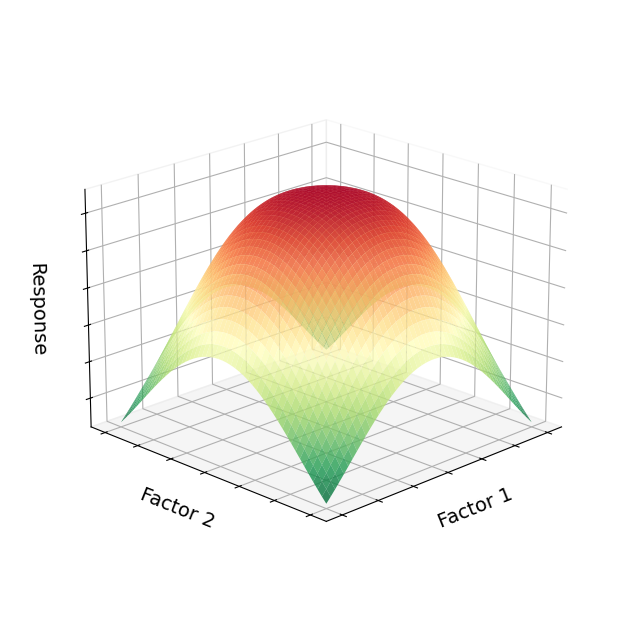

In [63]:
# Create a grid of x and y values
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)

# Create a bell-shaped surface (2D Gaussian with flatter top)
sigma_x = 2.5
sigma_y = 2.5
amplitude = 1.5
power = 1.5

Z = amplitude * np.exp(-(X ** 2 / (2 * sigma_x ** 2) + Y ** 2 / (2 * sigma_y ** 2)) ** power)

# Create the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create the surface plot with color mapping
surface = ax.plot_surface(X, Y, Z,
                          cmap='RdYlGn_r',  # Red-Yellow-Green colormap (reversed)
                          alpha=0.8,
                          linewidth=0,
                          antialiased=True)

# Customize the plot
ax.set_xlabel('Factor 1', fontsize=14)
ax.set_ylabel('Factor 2', fontsize=14)
ax.set_zlabel('Response', fontsize=14)

ax.get_xaxis().set_ticklabels([])
ax.get_yaxis().set_ticklabels([])
ax.get_zaxis().set_ticklabels([])

# Set the viewing angle to match the image
ax.view_init(elev=20, azim=225)

# Show grid
ax.grid(True, alpha=0.3)

# Set background color
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False

ax.set_box_aspect(None, zoom=0.85)
plt.show()